# Loading the MNIST dataset

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Shuffling the dataset

In [2]:
import numpy as np
np.random.seed(0)
shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]
print(f"Training data dimensions: {x_train.shape}")

Training data dimensions: (60000, 28, 28)


# Showing some samples along with their labels

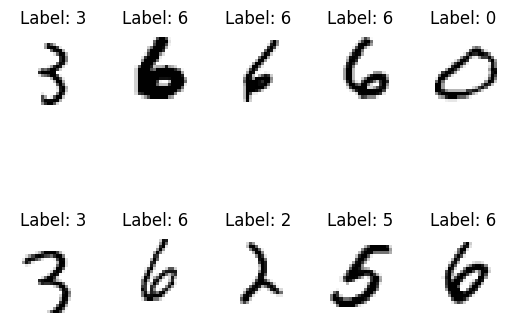

In [3]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(f"Label: {y_train[i]}")
plt.show()


# Normalizing the dataset

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Preparing labels and make them into categorical form

In [5]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
x_train.shape

(60000, 28, 28)

# Defining the model

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train.reshape(-1, 28, 28, 1), y_train, epochs=15, batch_size=64)

Epoch 1/15
938/938 [==============================] - 90s 94ms/step - loss: 0.1634 - accuracy: 0.9499
Epoch 2/15
938/938 [==============================] - 84s 90ms/step - loss: 0.0458 - accuracy: 0.9859
Epoch 3/15
938/938 [==============================] - 86s 92ms/step - loss: 0.0326 - accuracy: 0.9895
Epoch 4/15
938/938 [==============================] - 84s 89ms/step - loss: 0.0246 - accuracy: 0.9922
Epoch 5/15
938/938 [==============================] - 85s 91ms/step - loss: 0.0205 - accuracy: 0.9933
Epoch 6/15
938/938 [==============================] - 83s 89ms/step - loss: 0.0161 - accuracy: 0.9948
Epoch 7/15
938/938 [==============================] - 86s 92ms/step - loss: 0.0141 - accuracy: 0.9955
Epoch 8/15
938/938 [==============================] - 84s 89ms/step - loss: 0.0122 - accuracy: 0.9958
Epoch 9/15
938/938 [==============================] - 84s 89ms/step - loss: 0.0109 - accuracy: 0.9963
Epoch 10/15
938/938 [==============================] - 84s 89ms/step - loss: 0.008

# Grad-CAM Algorithm
## I used this link: https://keras.io/examples/vision/grad_cam/

In [9]:
import tensorflow as tf
import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Model summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Using Grad-CAM algorithm to visualize last convolutional layer's output on 10 samples

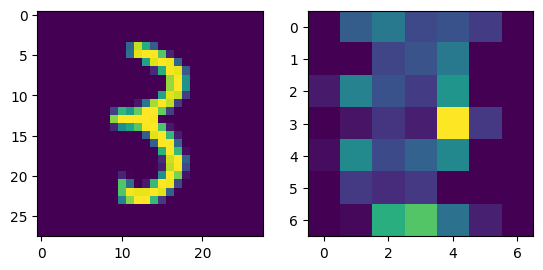

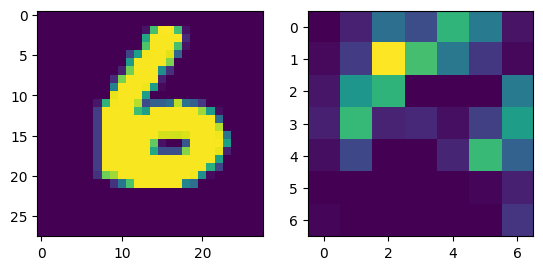

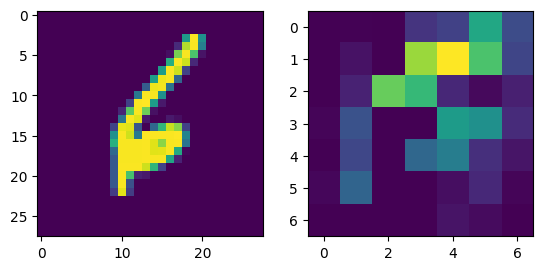

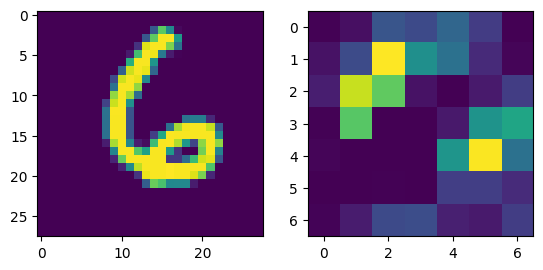

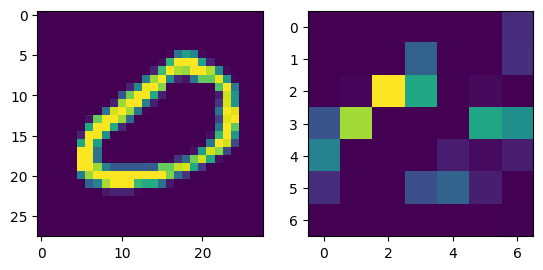

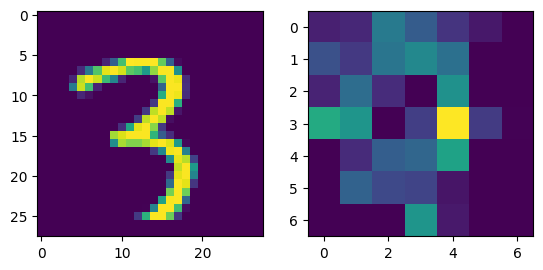

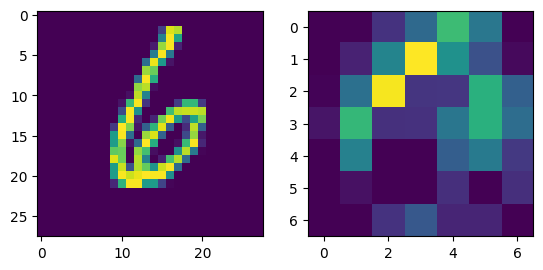

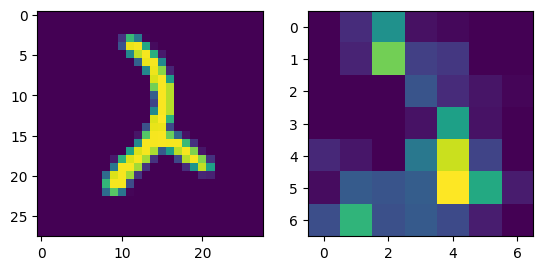

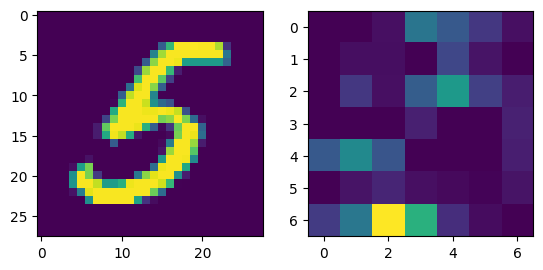

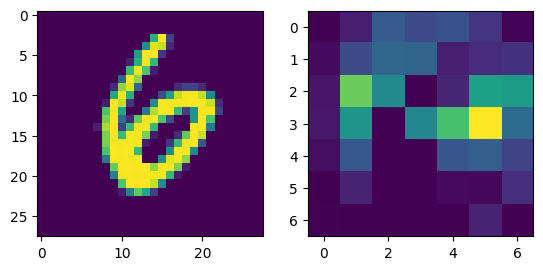

In [16]:
# Remove last layer's softmax
model.layers[-1].activation = None
# last convolutional layer
last_conv_layer_name = "conv2d_2"
for i in range(10):
    img_array = np.expand_dims(x_train[i], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(x_train[i])
    axs[1].imshow(heatmap)
    plt.show()